Dataset: https://www.kaggle.com/datasets/loulouashley/nhsadmissions-and-gp-referrals

Data Source: Quarterly Hospital Activity Data (https://www.england.nhs.uk/statistics/statistical-work-areas/hospital-activity/quarterly-hospital-activity/qar-data/)

Kaggle original: https://www.kaggle.com/code/loulouashley/nhs-time-series-study-admissions-gp-referrals

<< A random practice >>

# NHS Admissions and GP referrals

Type: Time series analysis

In [1]:
# checking python version
from platform import python_version
print(python_version())

import pandas as pd
print(pd.__version__)

3.9.7
1.4.3


In [2]:
# import libraries
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import itertools


<Figure size 1000x600 with 0 Axes>

In [3]:
df = pd.read_excel("../datasets/NHS-Admissions.xls")

In [4]:
# Checking % of missing values in columns
def check_missing_values(df):
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))

In [5]:
df.head(5)

,Year,Month,Day,Specialty Code,Specialty Name,Decisions to Admit,Admissions,Failed to Attend,Removals,Deferred admissions,Patients Suspended,GP Referrals Made,Other Referrals Made,First Attendances Seen,First Attendances DNA,Subsequent Attendances Seen,Subsequent Attendances DNA
0,2008,6,1,C_999,Total,1182425,1063433,23595,157446,43986,44532,2655581.000,1.462796e+06,3661937,343937,7854773,1000206
1,2008,9,1,C_999,Total,1199964,1087367,25920,156115,45368,42254,2643823.264,1.463597e+06,3731940,365462,7883778,1017999
2,2008,12,1,C_999,Total,1217895,1094776,25081,164242,50124,52006,2552289.424,1.470639e+06,3775186,368552,7969423,1021504
3,2008,3,1,C_999,Total,1229108,1116562,25313,163881,43875,38526,2716094.000,1.512271e+06,3784347,352345,8100045,1051220
4,2009,6,1,C_999,Total,1250250,1105491,24984,159466,42671,43105,2808565.000,1.560909e+06,3945308,367391,8195380,1007916


In [6]:
df.shape

(48, 17)

There are 48 records(rows) and 17 cols in this dataset. 

In [7]:
# combining Year, Month and Day varialbes as a new date variable
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors = 'coerce')
df = df.sort_values(by = 'Date', ascending = True)

In [8]:
# drop the unnecessary columns
df = df.drop(['Year','Month', 'Day'], axis = 1) 

In [9]:
df.head(5)

,Specialty Code,Specialty Name,Decisions to Admit,Admissions,Failed to Attend,Removals,Deferred admissions,Patients Suspended,GP Referrals Made,Other Referrals Made,First Attendances Seen,First Attendances DNA,Subsequent Attendances Seen,Subsequent Attendances DNA,Date
3,C_999,Total,1229108,1116562,25313,163881,43875,38526,2716094.000,1.512271e+06,3784347,352345,8100045,1051220,2008-03-01
0,C_999,Total,1182425,1063433,23595,157446,43986,44532,2655581.000,1.462796e+06,3661937,343937,7854773,1000206,2008-06-01
1,C_999,Total,1199964,1087367,25920,156115,45368,42254,2643823.264,1.463597e+06,3731940,365462,7883778,1017999,2008-09-01
2,C_999,Total,1217895,1094776,25081,164242,50124,52006,2552289.424,1.470639e+06,3775186,368552,7969423,1021504,2008-12-01
7,C_999,Total,1290450,1168811,25957,181311,46660,39622,2788045.000,1.564183e+06,4021017,390378,8605578,1083132,2009-03-01


In [10]:
check_missing_values(df)

Specialty Code - 0%
Specialty Name - 0%
Decisions to Admit - 0%
Admissions - 0%
Failed to Attend - 0%
Removals - 0%
Deferred admissions - 0%
Patients Suspended  - 0%
GP Referrals Made - 0%
Other Referrals Made - 0%
First Attendances Seen - 0%
First Attendances DNA - 0%
Subsequent Attendances Seen - 0%
Subsequent Attendances DNA - 0%
Date - 0%


In [11]:
# checking the data types
df.dtypes

Specialty Code                         object
Specialty Name                         object
Decisions to Admit                      int64
Admissions                              int64
Failed to Attend                        int64
Removals                                int64
Deferred admissions                    object
Patients Suspended                     object
GP Referrals Made                     float64
Other Referrals Made                  float64
First Attendances Seen                  int64
First Attendances DNA                   int64
Subsequent Attendances Seen             int64
Subsequent Attendances DNA              int64
Date                           datetime64[ns]
dtype: object

In [12]:
# checking zero values in each variable
(df == 0).sum()

Specialty Code                  0
Specialty Name                  0
Decisions to Admit              0
Admissions                      0
Failed to Attend                0
Removals                        0
Deferred admissions            39
Patients Suspended             39
GP Referrals Made               0
Other Referrals Made            0
First Attendances Seen          0
First Attendances DNA           0
Subsequent Attendances Seen     0
Subsequent Attendances DNA      0
Date                            0
dtype: int64

In Deferred admissions and Patients Suspended columns, there are 39 rows(among 48 in total) with lack of data, so we're going to remove them from future analysis process. 

Further data analysis will perform on Numerical values only, so Specialty Code and Specialty Name columns are also going to drop. 

In [13]:
df_dropped = df.drop(['Patients Suspended ','Deferred admissions', 'Specialty Code', 'Specialty Name'], axis = 1) 

In [14]:
df_dropped.shape

(48, 11)

In [15]:
# cols = list(df_dropped.columns.values)
# changing the order of the columns
df_dropped = df_dropped[['Date', 
 'Decisions to Admit',
 'Admissions',
 'Failed to Attend',
 'Removals',
 'GP Referrals Made',
 'Other Referrals Made',
 'First Attendances Seen',
 'First Attendances DNA',
 'Subsequent Attendances Seen',
 'Subsequent Attendances DNA']]

In [16]:
df_dropped.head(5)

,Date,Decisions to Admit,Admissions,Failed to Attend,Removals,GP Referrals Made,Other Referrals Made,First Attendances Seen,First Attendances DNA,Subsequent Attendances Seen,Subsequent Attendances DNA
3,2008-03-01,1229108,1116562,25313,163881,2716094.000,1.512271e+06,3784347,352345,8100045,1051220
0,2008-06-01,1182425,1063433,23595,157446,2655581.000,1.462796e+06,3661937,343937,7854773,1000206
1,2008-09-01,1199964,1087367,25920,156115,2643823.264,1.463597e+06,3731940,365462,7883778,1017999
2,2008-12-01,1217895,1094776,25081,164242,2552289.424,1.470639e+06,3775186,368552,7969423,1021504
7,2009-03-01,1290450,1168811,25957,181311,2788045.000,1.564183e+06,4021017,390378,8605578,1083132


### Data cleaning is done.

In [17]:
df_dropped['Admissions'].describe()

count    4.800000e+01
mean     1.331726e+06
std      1.274778e+05
min      1.063433e+06
25%      1.254063e+06
50%      1.353638e+06
75%      1.443568e+06
max      1.493892e+06
Name: Admissions, dtype: float64

<Axes: >

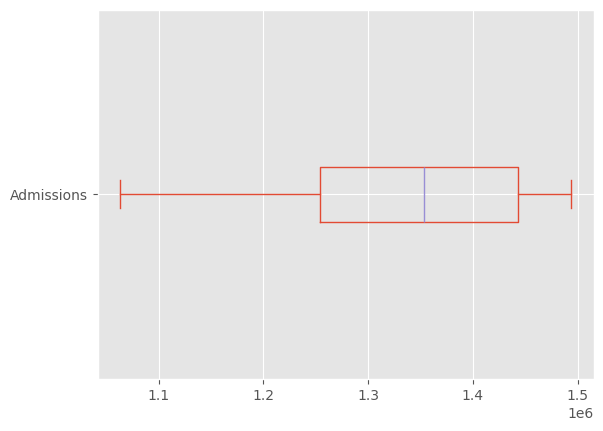

In [18]:
# detecting outliers
df_dropped['Admissions'].plot(kind = 'box', vert = False)

### Inpatient activity over Years

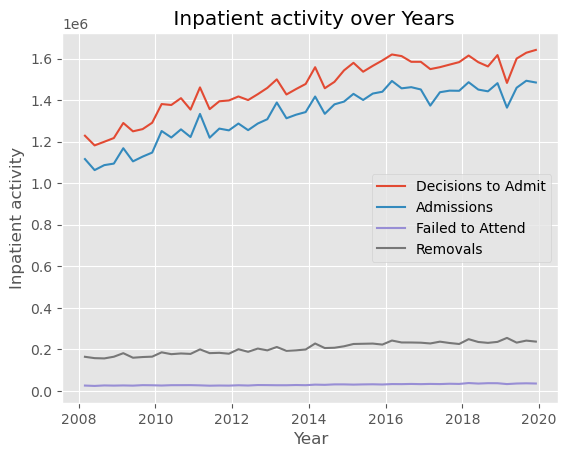

In [19]:
# plot the inpatient activity over years
plt.plot(df_dropped["Date"], df_dropped["Decisions to Admit"], label="Decisions to Admit")
plt.plot(df_dropped["Date"], df_dropped["Admissions"], label="Admissions")
plt.plot(df_dropped["Date"], df_dropped["Failed to Attend"], label="Failed to Attend")
plt.plot(df_dropped["Date"], df_dropped["Removals"], label="Removals")
plt.title(" Inpatient activity over Years")
plt.xlabel("Year")
plt.ylabel("Inpatient activity")
plt.legend()

plt.show()

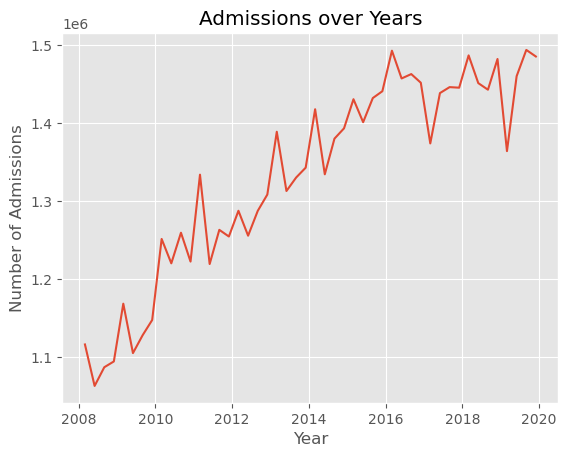

In [20]:
# Admissions over Years
plt.plot(df_dropped["Date"], df_dropped["Admissions"])
plt.title("Admissions over Years")
plt.xlabel("Year")
plt.ylabel("Number of Admissions")
plt.show()

In [21]:
df_new = df_dropped.copy('deep')
df_new['Year'] = df_new['Date'].dt.year
df_new['Month'] = df_new['Date'].dt.month
df_new.head()

,Date,Decisions to Admit,Admissions,Failed to Attend,Removals,GP Referrals Made,Other Referrals Made,First Attendances Seen,First Attendances DNA,Subsequent Attendances Seen,Subsequent Attendances DNA,Year,Month
3,2008-03-01,1229108,1116562,25313,163881,2716094.000,1.512271e+06,3784347,352345,8100045,1051220,2008,3
0,2008-06-01,1182425,1063433,23595,157446,2655581.000,1.462796e+06,3661937,343937,7854773,1000206,2008,6
1,2008-09-01,1199964,1087367,25920,156115,2643823.264,1.463597e+06,3731940,365462,7883778,1017999,2008,9
2,2008-12-01,1217895,1094776,25081,164242,2552289.424,1.470639e+06,3775186,368552,7969423,1021504,2008,12
7,2009-03-01,1290450,1168811,25957,181311,2788045.000,1.564183e+06,4021017,390378,8605578,1083132,2009,3


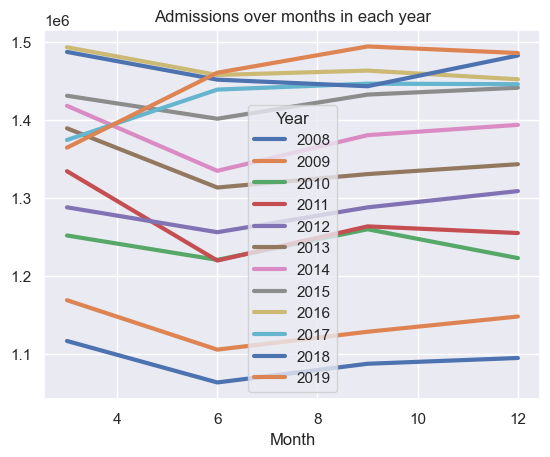

In [22]:
# checking Admissions over months in each year
sns.set()
season = df_new
spivot = pd.pivot_table(season, index='Month', columns = 'Year', values = 'Admissions', aggfunc=np.mean)
spivot.plot(linewidth=3)
plt.title("Admissions over months in each year")
plt.show()

### Correlation Analysis

In [23]:
# Correlation between different variables
corr = df_dropped.corr()
corr

,Decisions to Admit,Admissions,Failed to Attend,Removals,GP Referrals Made,Other Referrals Made,First Attendances Seen,First Attendances DNA,Subsequent Attendances Seen,Subsequent Attendances DNA
Decisions to Admit,1.000000,0.994284,0.845805,0.943308,0.943716,0.923613,0.967416,0.888752,0.978634,-0.490264
Admissions,0.994284,1.000000,0.852577,0.952725,0.946619,0.926590,0.966281,0.888015,0.982654,-0.499132
Failed to Attend,0.845805,0.852577,1.000000,0.885196,0.884664,0.921176,0.934451,0.943435,0.886997,-0.422426
Removals,0.943308,0.952725,0.885196,1.000000,0.919499,0.938251,0.954433,0.891162,0.973431,-0.533112
GP Referrals Made,0.943716,0.946619,0.884664,0.919499,1.000000,0.910379,0.952810,0.894756,0.950498,-0.406166
Other Referrals Made,0.923613,0.926590,0.921176,0.938251,0.910379,1.000000,0.967482,0.895290,0.958160,-0.626328
First Attendances Seen,0.967416,0.966281,0.934451,0.954433,0.952810,0.967482,1.000000,0.954806,0.980844,-0.484500
First Attendances DNA,0.888752,0.888015,0.943435,0.891162,0.894756,0.895290,0.954806,1.000000,0.903434,-0.337737
Subsequent Attendances Seen,0.978634,0.982654,0.886997,0.973431,0.950498,0.958160,0.980844,0.903434,1.000000,-0.533380
Subsequent Attendances DNA,-0.490264,-0.499132,-0.422426,-0.533112,-0.406166,-0.626328,-0.484500,-0.337737,-0.533380,1.000000


Based on above Correlation Matrix, "Subsequent Attendances DNA" column is not correlated with the rest of columns(it is the only one feature which is negatively correlated with the rest). So we're going to drop it to see clearly the correlation among the rest columns.

<Axes: >

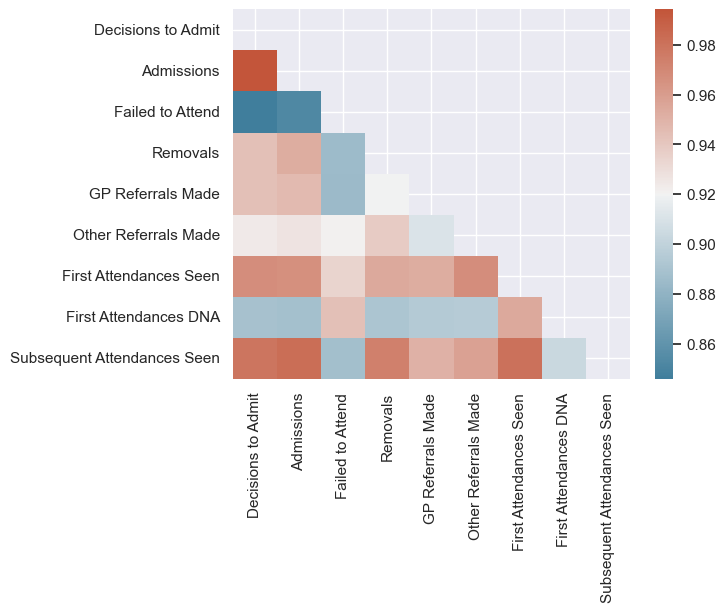

In [24]:
df_2 = df_dropped.drop(['Subsequent Attendances DNA'], axis = 1)

# New Correlation Matrix
corr_2 = df_2.corr() 

# Set up the matplotlib plot configuration
f, ax = plt.subplots()
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr_2, dtype=bool))
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr_2, mask = mask, cmap=cmap)

Decisions to Admit, Admissions, Subsequent Attenance Seen and First Attendances Seen are highly correlated. \
Removals, GP Referrals Made and Other Referrals Made are also closely correlated. \
Failed to Attend and First Attendances DNA are a bit correlated.

### Prediction Model

Keeping Date and Admissions columns only for Univariate time series analysis

In [25]:
df_ts = df_2[['Date', 'Admissions']]
df_ts.head()

,Date,Admissions
3,2008-03-01,1116562
0,2008-06-01,1063433
1,2008-09-01,1087367
2,2008-12-01,1094776
7,2009-03-01,1168811


In [26]:
df_ts.dtypes

Date          datetime64[ns]
Admissions             int64
dtype: object

Clearly this is a univariate time series — we want to make sure the index is the timestep rather than the random Pandas one.

In [27]:
df_ts.set_index('Date', inplace=True, drop=True)
df_ts.index = pd.to_datetime(df_ts.index)
df_ts.dtypes

Admissions    int64
dtype: object

In [28]:
df_ts.head()

,Admissions
Date,
2008-03-01,1116562
2008-06-01,1063433
2008-09-01,1087367
2008-12-01,1094776
2009-03-01,1168811


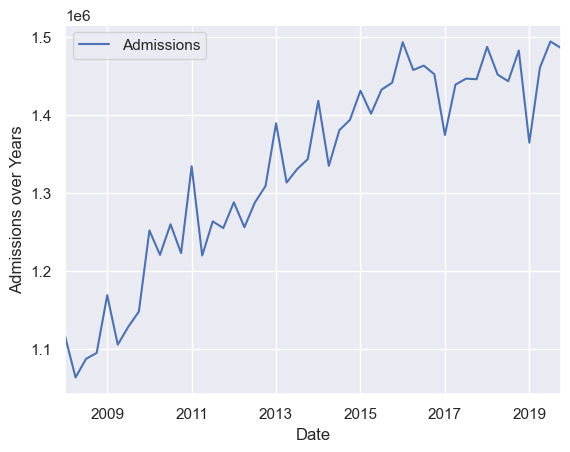

In [29]:
ax = df_ts.plot()
ax.set_ylabel('Admissions over Years')
ax.set_xlabel('Date')
plt.show()

Inspect through resampling — helpful for visualising potentional trend and/or seasonal patterns.

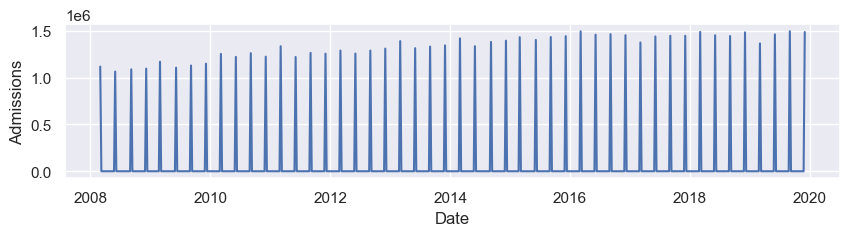

In [61]:
df_by_week = df_ts.resample('W').sum()

fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(10, 2)
sns.lineplot(x = df_by_week.index, y="Admissions", data = df_by_week, ax=ax1);

# Is the data stationary? 
Dickey-Fuller test

Null hypothesis of the test is that the time series is **non-stationary**. [It has some time dependent structure.]\
Alternate hypothesis (rejecting the null hypothesis) is that the time series is **stationary**.


A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary, otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [31]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df_ts['Admissions'])
print("pvalue = ", pvalue)

pvalue =  0.005174681146050759


#### This time series data is Stationary.

In [32]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
#     plt.xticks(fontsize = 25)
#     plt.yticks(fontsize = 25)
    
    plt.xlabel('Time in Years')
    plt.ylabel('Total Admissions')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block= True)

In [33]:
df_ts = df_ts.sort_values(by = 'Date', ascending = True)

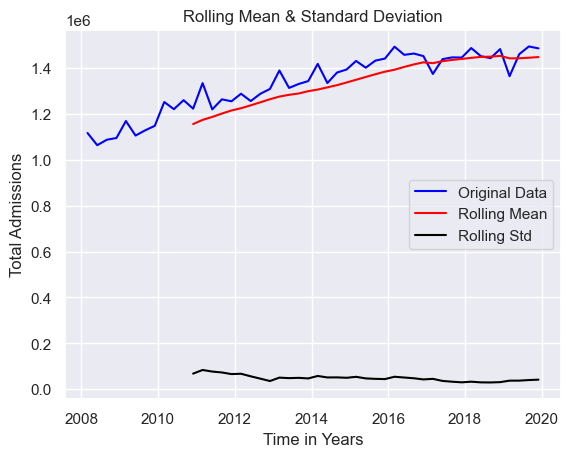

In [34]:
TestStationaryPlot(df_ts)

In [35]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [36]:
TestStationaryAdfuller(df_ts)

Test Statistic                 -3.632186
p-value                         0.005175
#Lags Used                      7.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [37]:
df_ts.shape

(48, 1)

If the dataset is not stationary, we must transform it to be stationary.

#### Method 1 : The moving average

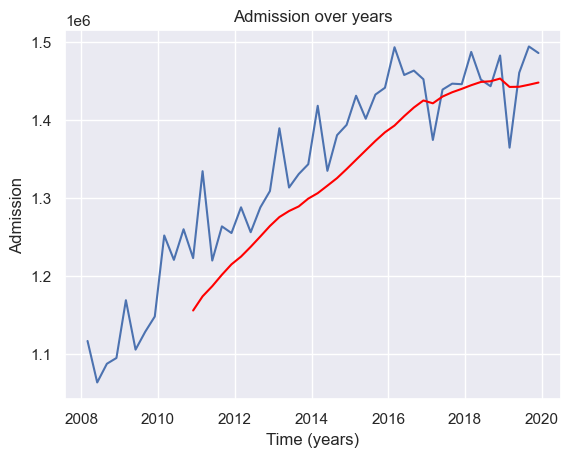

In [38]:
moving_avg = df_ts.rolling(12).mean()
plt.plot(df_ts)
plt.plot(moving_avg, color='red')
plt.xlabel('Time (years)')
plt.ylabel('Admission')
plt.title('Admission over years')
plt.show()

In [39]:
df3_moving_avg_diff = df_ts - moving_avg
df3_moving_avg_diff.head(13)

,Admissions
Date,
2008-03-01,NaN
2008-06-01,NaN
2008-09-01,NaN
2008-12-01,NaN
2009-03-01,NaN
2009-06-01,NaN
2009-09-01,NaN
2009-12-01,NaN
2010-03-01,NaN


In [40]:
df3_moving_avg_diff.dropna(inplace=True)
df3_moving_avg_diff.head(13)

,Admissions
Date,
2010-12-01,67113.916667
2011-03-01,160336.916667
2011-06-01,32838.916667
2011-09-01,61964.000000
2011-12-01,40087.916667
2012-03-01,63139.083333
2012-06-01,18692.916667
2012-09-01,37246.083333
2012-12-01,44716.333333


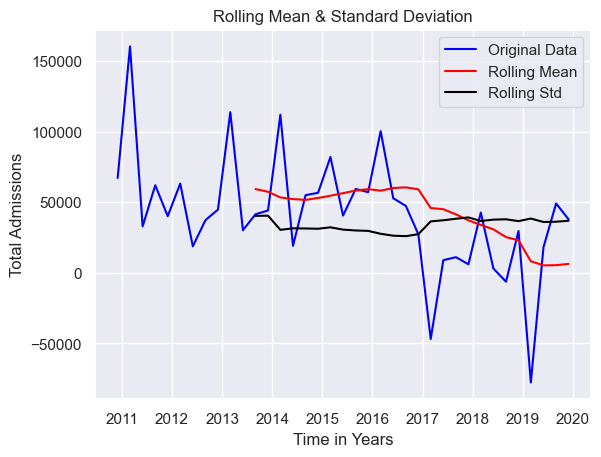

In [41]:
TestStationaryPlot(df3_moving_avg_diff)

In [42]:
TestStationaryAdfuller(df3_moving_avg_diff)

Test Statistic                 -4.663272
p-value                         0.000099
#Lags Used                      0.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


#### Second method : Differencing

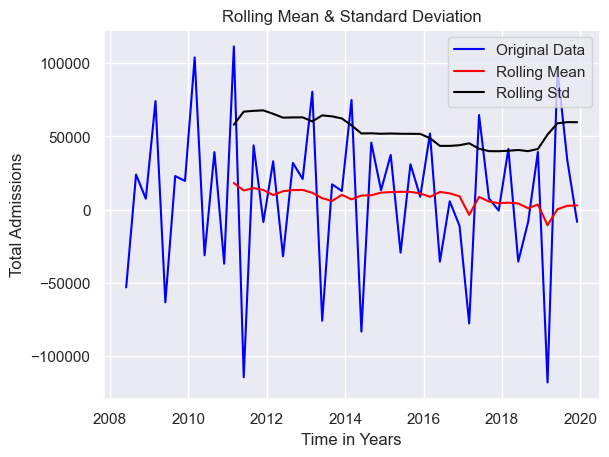

Test Statistic                 -2.349086
p-value                         0.156625
#Lags Used                      7.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [43]:
df3_first_difference = df_ts - df_ts.shift(1)  
TestStationaryPlot(df3_first_difference.dropna(inplace=False))
TestStationaryAdfuller(df3_first_difference.dropna(inplace=False))

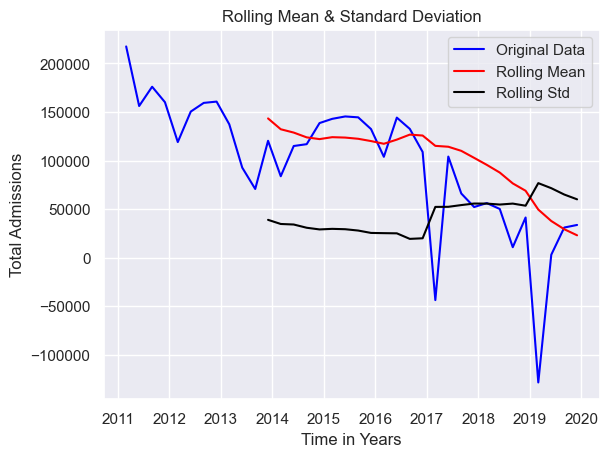

Test Statistic                 -1.780257
p-value                         0.390307
#Lags Used                      1.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [44]:
df3_seasonal_difference = df_ts - df_ts.shift(12)  
TestStationaryPlot(df3_seasonal_difference.dropna(inplace=False))
TestStationaryAdfuller(df3_seasonal_difference.dropna(inplace=False))

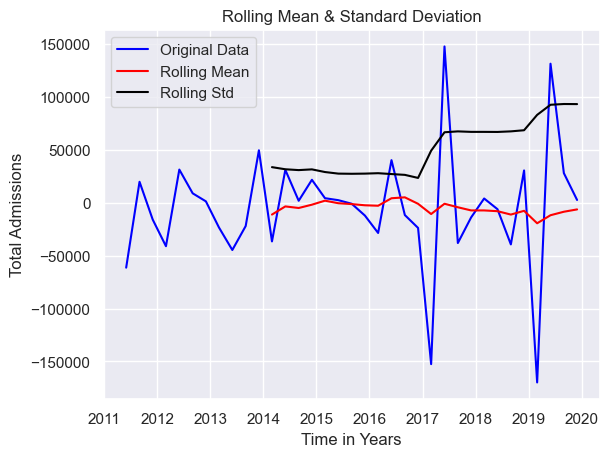

Test Statistic                -9.666897e+00
p-value                        1.307909e-16
#Lags Used                     0.000000e+00
Number of Observations Used    3.400000e+01
Critical Value (1%)           -3.639224e+00
Critical Value (5%)           -2.951230e+00
Critical Value (10%)          -2.614447e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [45]:
df3_seasonal_first_difference = df3_first_difference - df3_first_difference.shift(12)  
TestStationaryPlot(df3_seasonal_first_difference.dropna(inplace=False))
TestStationaryAdfuller(df3_seasonal_first_difference.dropna(inplace=False))

#### Eliminating trend and seasonality: Decomposing

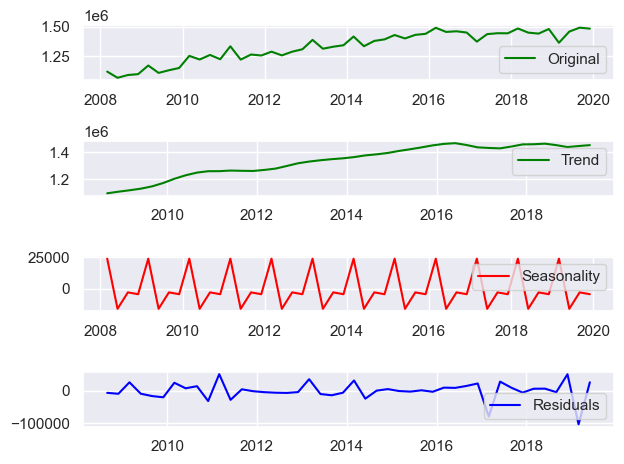

In [46]:
#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 

decomposition = seasonal_decompose(df_ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_ts, label='Original', color='green')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='red')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

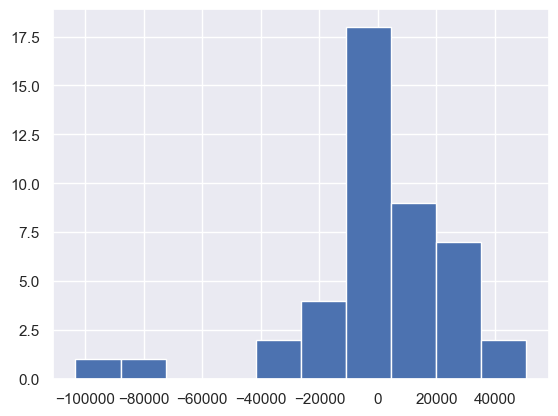

In [47]:
hist = residual.hist()

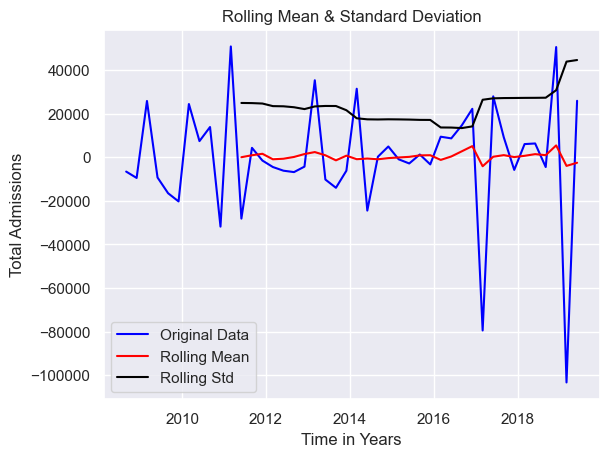

Test Statistic                -6.176601e+00
p-value                        6.607474e-08
#Lags Used                     6.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (1%)           -3.620918e+00
Critical Value (5%)           -2.943539e+00
Critical Value (10%)          -2.610400e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [48]:
df3_decompose = residual
df3_decompose.dropna(inplace=True)
TestStationaryPlot(df3_decompose)
TestStationaryAdfuller(df3_decompose)

#### Find optimal parameters and build SARIMA model

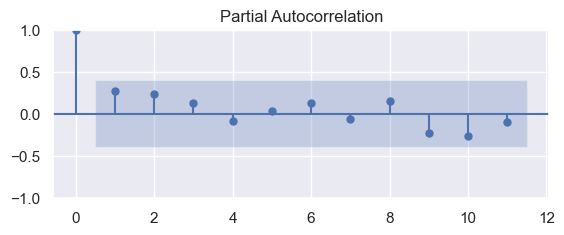

In [62]:
fig = plt.figure()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df3_moving_avg_diff.iloc[13:], lags=11, ax=ax2, method='ywm')

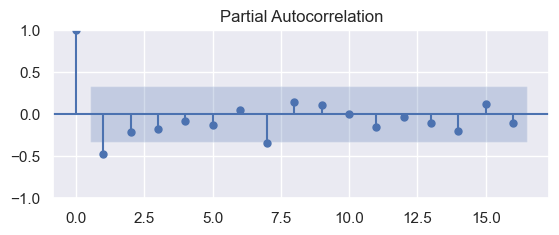

In [63]:
fig = plt.figure()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df3_seasonal_first_difference.iloc[13:], lags=16, ax=ax2, method='ywm')

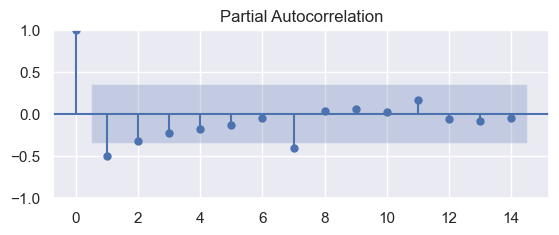

In [64]:
fig = plt.figure()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df3_decompose.iloc[13:], lags=14, ax=ax2, method='ywm')

In [52]:
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)


In [53]:
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(mte,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [54]:
#mod = sm.tsa.statespace.SARIMAX(df3_moving_avg_diff, 
#                                order=(1,1,1), 
#                                seasonal_order=(0,1,1,12),   
#                                enforce_stationarity=False,
#                                enforce_invertibility=False)
#results = mod.fit()
#print(results.summary())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

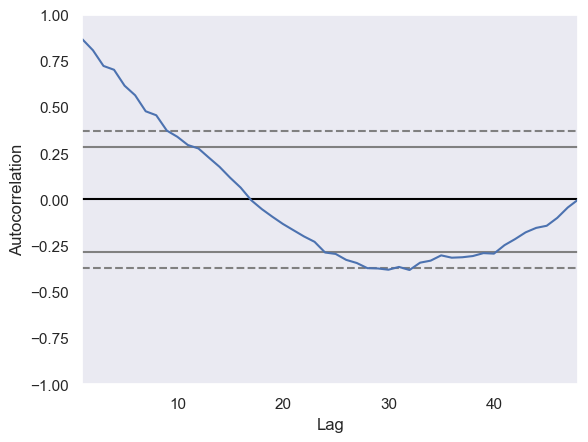

In [65]:
from pandas.plotting import autocorrelation_plot

# autocorrelation_plot(df.Passengers)
autocorrelation_plot(df_ts)

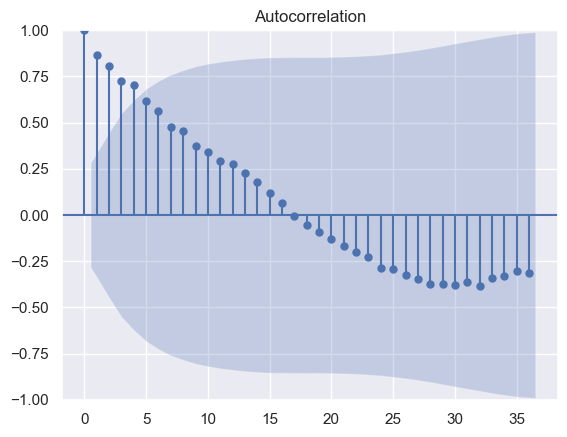

In [56]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df_ts, lags=36) 
plt.show()

#plot_pacf(df_ts, lags=23) 
#plt.show()